# Self-Organizing Maps with Fastai

This notebook contains example usage of a Fastai-based SOM implementation on various datasets.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /proj/kg_som

/proj/kg_som


In [438]:
import torch
from torch import Tensor
from sklearn.datasets import load_iris
from typing import Tuple
from itertools import combinations_with_replacement, product

import random
import numpy as np
import matplotlib.pyplot as plt

def colors_github():
    # Set color dataset
    colors = np.empty((0,3), float)
    colors = np.append(colors, np.array([[0, 0, 0]]), axis=0)
    colors = np.append(colors, np.array([[1, 1, 1]]), axis=0)
    for i in range(20):
        colors = np.append(colors, np.array([[0, 0, random.random()]]), axis=0)
        colors = np.append(colors, np.array([[0, random.random(), 0]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), 0, 0]]), axis=0)
        colors = np.append(colors, np.array([[1, 1, random.random()]]), axis=0)
        colors = np.append(colors, np.array([[1, random.random(), 1]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), 1, 1]]), axis=0)
        colors = np.append(colors, np.array([[0, random.random(), random.random()]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), random.random(), 0]]), axis=0)
        colors = np.append(colors, np.array([[1, random.random(), random.random()]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), random.random(), 1]]), axis=0)
        colors = np.append(colors, np.array([[random.random(), random.random(), random.random()]]), axis=0)
    x = torch.tensor(colors)
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (10, 10)
    alpha = 0.03
    bs = x.shape[0]
    epochs = 1000
    return x, y, labels, map_size, alpha, bs, epochs

def iris():
    "Loads the IRIS dataset into two tensors."
    iris = load_iris()
    x = torch.tensor(iris.data)
    y = torch.tensor(iris.target)
    labels = iris.feature_names
    map_size = (4,4)
    alpha = 0.3
    bs = 10
    epochs = 30
    return x, y, labels, map_size, alpha, bs, epochs

def colors_uniform():
    k = 20
    x = [list(x) for x in product(list(range(k)), repeat=3)]
    from random import shuffle
    shuffle(x)
    x = torch.FloatTensor(x) * (255 / (k-1));
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (10, 10)
    alpha = 0.3
    bs = 128
    epochs = 300
    return x, y, labels, map_size, alpha, bs, epochs

def colors(n: int = 11000):
    "Loads a dataset containing all possible RGB color combinations"
#     x = torch.zeros(n, 3).normal_(mean=80.0, std=127.0).long().float()
    x = torch.zeros(n, 3).uniform_(0, 255).long().float()
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (10, 10)
    alpha = 0.03
    bs = 50
    epochs = 100
    return x, y, labels, map_size, alpha, bs, epochs


def colors_small():
    "Loads a dataset containing a small number of RGB color combinations"
    x = torch.FloatTensor([
        [3, 255, 0],
        [0, 247, 3],
        [0, 252, 5],
        [3, 239, 8],
        [0, 232, 3],
        [3, 255, 0],
        [0, 250, 5],
        [255, 3, 0],
        [247, 3, 0],
        [252, 5, 0],
        [239, 8, 3],
        [232, 0, 3],
        [255, 3, 3],
        [249, 5, 3],
        [247, 3, 5],
        [3, 0, 255],
        [3, 0, 247],
        [5, 0, 252],
        [8, 2, 239],
        [0, 3, 232],
        [3, 3, 255],
        [5, 3, 249],
        [3, 5, 247],
        [8, 3, 234],
        [3, 5, 247],
        [5, 3, 234],
    ])
    y = None
    labels = ['Red', 'Green', 'Blue']
    map_size = (3, 3)
    alpha = 0.01
    bs = 4
    epochs = 100
    return x, y, labels, map_size, alpha, bs, epochs

def uniform(n: int = 11000, s: int = 3):
    "Loads a uniform dataset"
    x = torch.randn(n, s)
    y = None
    labels = list(range(s))
    map_size = (6, 6)
    alpha = 0.03
    bs = 50
    epochs = 150
    return x, y, labels, map_size, alpha, bs, epochs
    

## Create the dataset

We use one of the data loading functions defined above together with the `UnsupervisedDataBunch` class.

In [439]:
from kg_som import UnsupervisedDataBunch

In [440]:
x, y, labels, map_size, alpha, bs, epochs = colors_github()

In [453]:
db = UnsupervisedDataBunch(x, valid=0.2, sampler='shuffle', bs=bs)

In [454]:
# db.normalize('minmax')

In [455]:
db.train_ds.tensors[0]

tensor([[6.8187e-01, 3.2732e-01, 1.0000e+00],
        [0.0000e+00, 4.1081e-04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.6898e-01],
        [0.0000e+00, 0.0000e+00, 6.4288e-01],
        [1.0000e+00, 3.7940e-01, 7.5380e-02],
        [5.8847e-01, 9.2571e-01, 4.7531e-01],
        [7.8298e-01, 2.9987e-01, 1.0000e+00],
        [5.7138e-01, 1.1497e-01, 0.0000e+00],
        [1.0000e+00, 2.3625e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.9809e-01],
        [0.0000e+00, 8.0977e-01, 5.6032e-01],
        [7.2702e-01, 7.0452e-01, 8.8281e-01],
        [1.0000e+00, 7.0801e-01, 8.7201e-01],
        [2.6744e-02, 4.9001e-01, 3.8829e-01],
        [5.9970e-01, 1.0000e+00, 1.0000e+00],
        [6.5719e-01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.5793e-01],
        [2.6544e-01, 3.7358e-01, 1.0000e+00],
        [6.6803e-02, 7.4359e-01, 0.0000e+00],
        [2.2437e-01, 9.6834e-02, 8.8926e-01],
        [1.0000e+00, 6.2186e-01, 8.4325e-02],
        [6.3090e-01, 0.0000e+00, 0

In [456]:
n_batches = x.shape[0] // bs
alpha, bs, epochs, n_batches

(0.03, 222, 100, 1)

## Create the Learner

First, let's define the hyperparameters:

In [457]:
from kg_som import SomLearner, Som
from kg_som import neigh_gauss, neigh_rhomb, neigh_square
from kg_som import neigh_diff_standard, neigh_diff_toroidal
from kg_som import pdist, pnorm, manhattan_dist
from kg_som import mean_quantization_err, topologic_err, codebook_err
from kg_som import ExperimentalSomTrainer, TwoPhaseSomTrainer, LinearDecaySomTrainer
from functools import partial

In [458]:
size = (map_size[0], map_size[1], x.shape[-1])
size

(10, 10, 3)

In [465]:
# Rhomb params
# som_hypers = dict(
#     size=size,
#     neigh_fn=neigh_rhomb,
#     dist_fn=pdist,
#     neigh_diff_fn=neigh_diff_standard,
# )

som_hypers = dict(
    size=size,
    dist_fn=pdist,
    neigh_fn=neigh_gauss,
    neigh_diff_fn=neigh_diff_standard,
)

learn_hypers = dict(
    lr=(0.3, 0.1, 0.2),
    metrics=[topologic_err, codebook_err],
    visualize=['weights', 'hyperparams', 'bmus'],
    trainer=ExperimentalSomTrainer,
)
epochs = 100

Then we can create a Som model of the required size and pass it to a `SomLearner`:

In [466]:
som = Som(**som_hypers)

In [467]:
learn = SomLearner(db, som, loss_func=mean_quantization_err, **learn_hypers)
learn.model

Som(
            size=(10, 10), neuron_size=3, alpha=tensor([0.0030], device='cuda:0'), sigma=tensor([5.], device='cuda:0')),
            dist_fn=pdist, neigh_fn=neigh_gauss, neigh_diff_fn=<function neigh_diff_standard at 0x7efafeab8378>)

## Training the model

This uses various SOM callback classes by default to visualize weights and update hyperparameters.

<IPython.core.display.Javascript object>


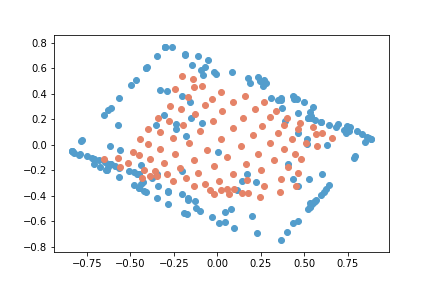

<IPython.core.display.Javascript object>


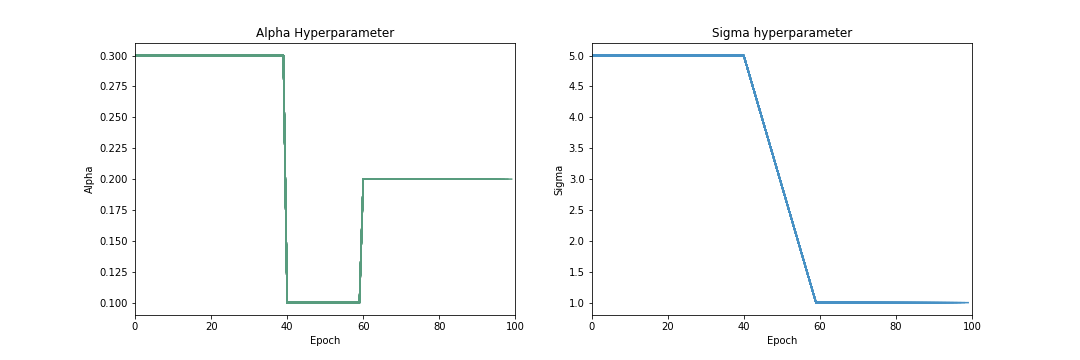

epoch,train_loss,valid_loss,topologic_err,codebook_err,time
0,0.164399,0.207436,13.000000,0.103111,00:00
1,0.179486,0.248013,13.000000,0.094000,00:00
2,0.196536,0.285922,12.000000,0.076444,00:00
3,0.213667,0.317569,7.000000,0.074667,00:00
4,0.229960,0.344852,4.000000,0.074889,00:00
5,0.244919,0.363308,2.000000,0.079111,00:00
6,0.258106,0.376776,2.000000,0.077111,00:00
7,0.269736,0.385165,2.000000,0.077778,00:00
8,0.279786,0.389490,3.000000,0.070889,00:00
9,0.288402,0.393272,3.000000,0.073556,00:00


<IPython.core.display.Javascript object>


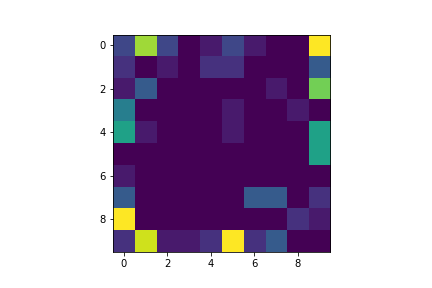

<IPython.core.display.Javascript object>


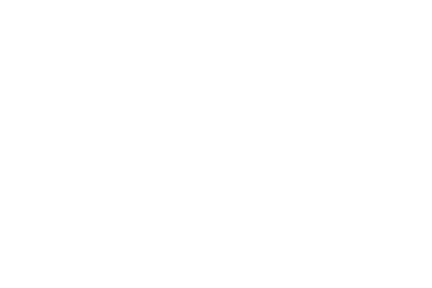

<IPython.core.display.Javascript object>


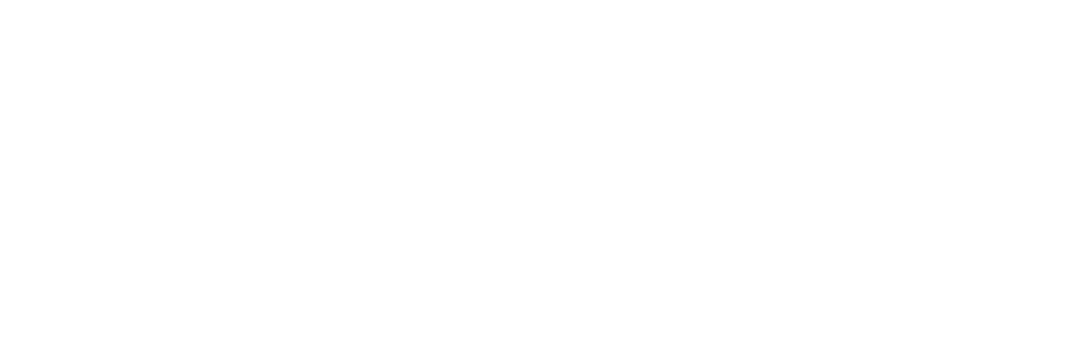

<IPython.core.display.Javascript object>


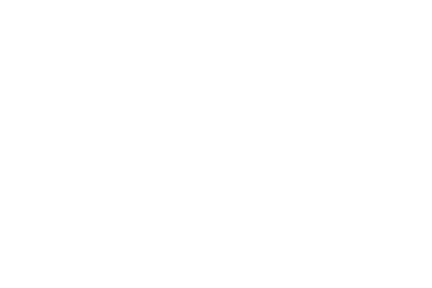

In [468]:
%matplotlib notebook
learn.fit(epochs)

## Plot losses

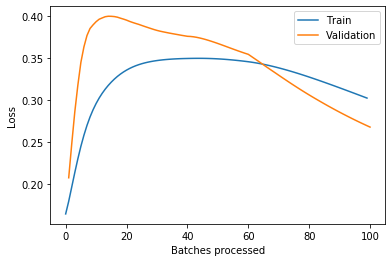

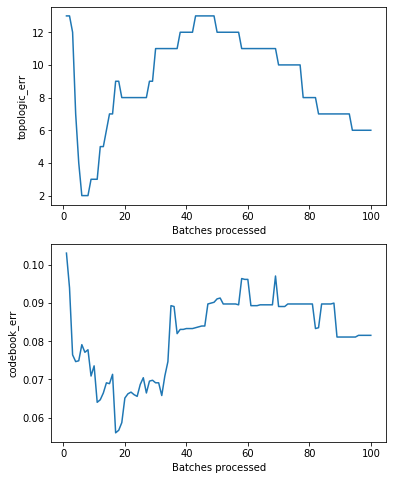

In [469]:
%matplotlib inline
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

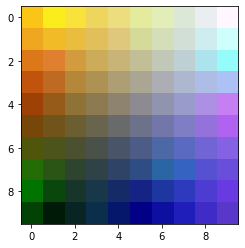

In [470]:
%matplotlib inline
def fn(d):
    return ((d - d.min(0)) / d.ptp(0) * 255).astype(int)
d = fn(learn.model.weights.view(-1, 3).cpu().numpy())
plt.imshow(d.reshape(learn.model.size))

In [437]:
som.weights[9,7]

tensor([0.3679, 0.2485, 0.1631], device='cuda:0', dtype=torch.float64)

In [434]:
red   = [255, 0, 0]
green = [0, 255, 0]
blue  = [0, 0, 255]

In [392]:
for color in [red, green, blue]:
    c = torch.tensor([color]).float()
    print(c)
    print(som.forward(c))

tensor([[255.,   0.,   0.]])
tensor([[6, 0]], device='cuda:0')
tensor([[  0., 255.,   0.]])
tensor([[9, 9]], device='cuda:0')
tensor([[  0.,   0., 255.]])
tensor([[0, 5]], device='cuda:0')


## Visualization

In [393]:
from kg_som import SomInterpretation

In [394]:
interp = SomInterpretation.from_learner(learn)

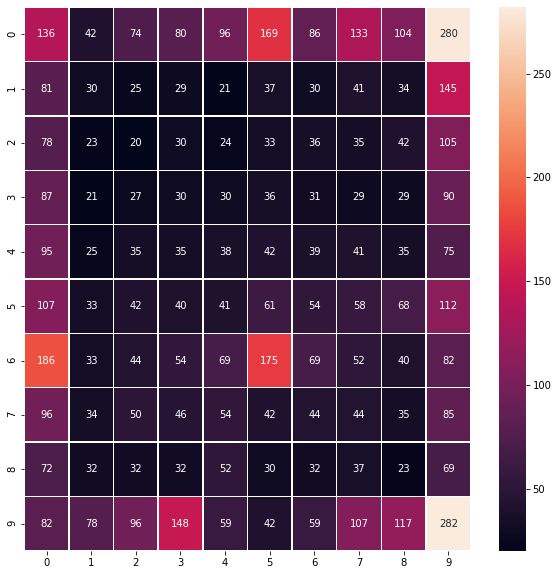

In [395]:
%matplotlib inline
interp.show_hitmap()

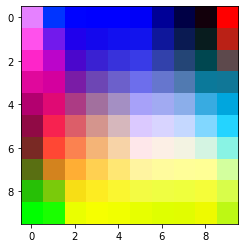

In [396]:
interp.show_weights()

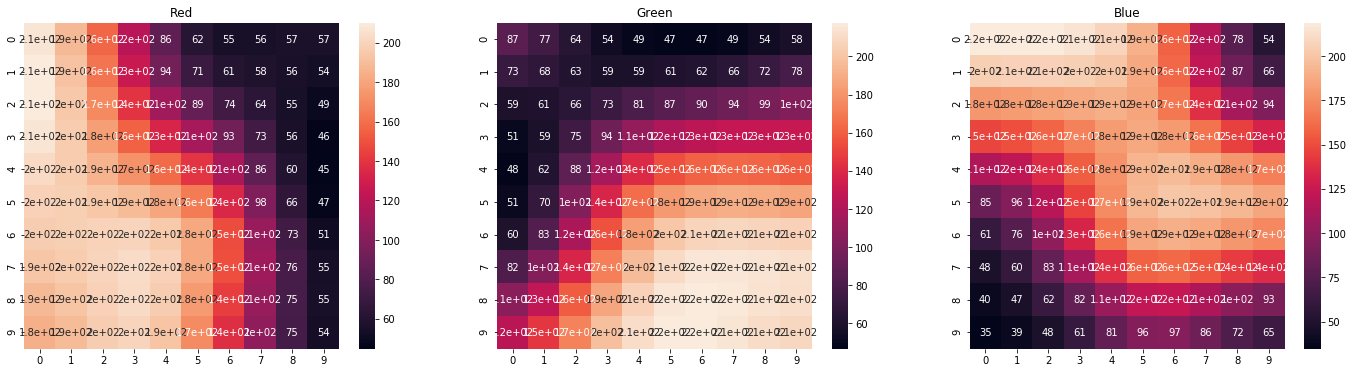

In [397]:
interp.show_feature_heatmaps(labels=labels)

## Hyperparams exploration

In [256]:
from typing import List, Tuple

def train_som(epochs, size, model_hypers, learn_hypers):
    "Trains a SOM with given hyperparameters."
    %matplotlib notebook    
    model = Som(size, **model_hypers)
    learn = SomLearner(db, model, **learn_hypers)
    learn.fit(epochs)
    return learn

def normalize_0_255(d):
    return ((d - d.min(0)) / d.ptp(0) * 255).astype(int)

def train_all(hypers: List[Tuple[int, Tuple, dict, dict]]):
    count = len(hypers)
    fig = plt.figure(figsize=(8,8))
    fignum = 1
    learns = []
    for epochs, size, model_hypers, learn_hypers in hypers:
        learn = train_som(epochs, size, model_hypers, learn_hypers)
        %matplotlib inline
        fig.add_subplot(count, 1, fignum) 
        d = normalize_0_255(learn.model.weights.view(-1, 3).cpu().numpy())
        plt.imshow(d.reshape(learn.model.size))
        fignum+=1
        plt.show()
        learns.append(learn)
    return learns

In [272]:
hypers = [
    (100, (5, 5, 3),   dict(neigh_fn=neigh_gauss), dict(visualize=['weights'], trainer=ExperimentalSomTrainer, lr=(0.3, 0.1, 0.03), metrics=[topologic_err, codebook_err])),
    (100, (10, 10, 3), dict(neigh_fn=neigh_gauss), dict(visualize=['weights'], trainer=ExperimentalSomTrainer, lr=(0.06, 0.1, 0.03), metrics=[topologic_err, codebook_err])),
    (100, (20, 20, 3), dict(neigh_fn=neigh_gauss), dict(visualize=['weights'], trainer=ExperimentalSomTrainer, lr=(0.06, 0.1, 0.03), metrics=[topologic_err, codebook_err])),
    (100, (40, 40, 3), dict(neigh_fn=neigh_gauss), dict(visualize=['weights'], trainer=ExperimentalSomTrainer, lr=(0.06, 0.1, 0.03), metrics=[topologic_err, codebook_err])),
]

<IPython.core.display.Javascript object>


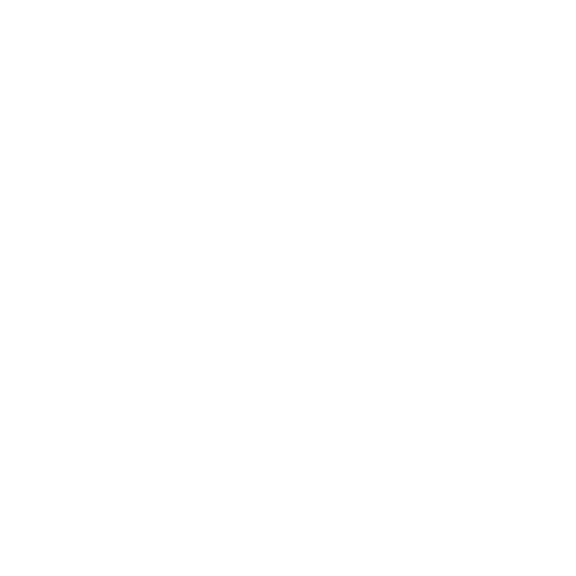

<IPython.core.display.Javascript object>


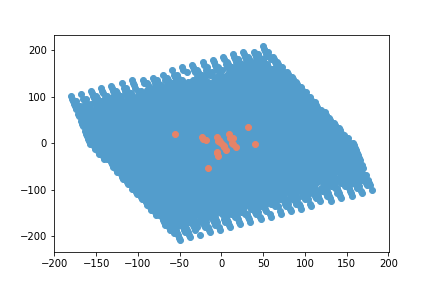

epoch,train_loss,valid_loss,topologic_err,codebook_err,time
0,85.846245,85.706879,88.599998,0.330800,00:00
1,85.355583,84.531036,88.320000,0.329625,00:00
2,85.009422,84.196648,87.480003,0.332725,00:00
3,84.787315,83.977203,86.760002,0.336650,00:00
4,84.662109,83.884628,85.800003,0.330925,00:00
5,84.599365,83.852318,85.720001,0.340550,00:00
6,84.567841,83.855621,85.120003,0.340225,00:00
7,84.557388,83.842918,85.120003,0.348825,00:00
8,84.553230,83.799843,85.080002,0.347400,00:00
9,84.562836,83.808624,85.199997,0.340300,00:00


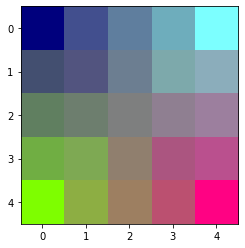

<IPython.core.display.Javascript object>


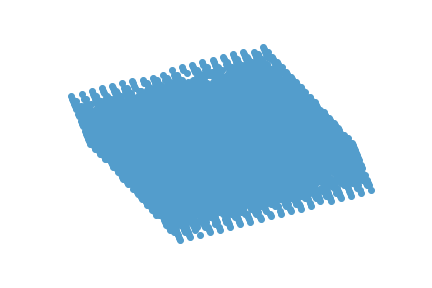

epoch,train_loss,valid_loss,topologic_err,codebook_err,time
0,58.074554,71.442535,42.799999,0.163650,00:00
1,73.077705,81.121262,51.799999,0.138269,00:00
2,79.423286,82.490875,48.720001,0.172594,00:00
3,81.104919,81.432983,46.240002,0.184706,00:00
4,80.821251,80.260033,45.119999,0.199881,00:00
5,80.090057,79.484268,44.680000,0.200113,00:00
6,79.455437,79.038101,44.759998,0.200737,00:00
7,79.014053,78.772850,44.759998,0.200319,00:00
8,78.732140,78.621330,44.360001,0.199456,00:00
9,78.552467,78.512169,44.240002,0.195687,00:00


KeyboardInterrupt: 

In [275]:
learns = train_all(hypers)

In [ ]:
delta, n, ed = recorder[0]['delta'], recorder[0]['n'], recorder[0]['ed']
delta.shape, n.shape, ed.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
learns[0].model.sigma

In [ ]:
n.shape

In [ ]:
delta[3][0][0]

In [ ]:
plt.imshow(n[24])

In [ ]:
n.min()

In [ ]:
learns[0].model.weights.view(-1, 3).min()

In [ ]:
# a.view(30, -1, 3).max(dim=0)

---

In [ ]:
# learn = learns[0]

In [ ]:
# v.show(som, what='codebook')

In [ ]:
!pip install git+https://github.com/sevamoo/sompy

In [ ]:
import sompy

In [ ]:
som = sompy.somFactory.build(x.cpu().numpy(), map_size, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='random', neighborhood='gaussian', training='batch', name='sompy')  # this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info', train_rough_len=22, train_finetune_len=8)  # verbose='debug' will print more, and verbose=None wont print anything

In [ ]:
v = sompy.mapview.View2DPacked(50, 50, 'test',text_size=8) 

In [ ]:
v.show??

In [ ]:
h = sompy.hitmap.HitMapView(10, 10, 'test')

In [ ]:
# h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

In [ ]:
sompy.hitmap.HitMapView(10, 10, 'test').show

In [ ]:
v.show(som, what='cluster')